In [136]:
import polars as pl
from utils import preprocessing
from datasets import load_dataset
from sklearn.model_selection import train_test_split

ds = load_dataset("fancyzhx/ag_news")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [137]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from gensim.models import Word2Vec

In [138]:
# Convertir chaque split en Polars DataFrame
subset_size = 120000

train_pl = pl.DataFrame(ds["train"][:subset_size])

In [139]:
label_names = ds["train"].features["label"].names
print(label_names)

train_pl = train_pl.with_columns([
    pl.col("label").map_elements(lambda x: label_names[x], return_dtype=pl.String).alias("label_name")
])

train_pl.head()

['World', 'Sports', 'Business', 'Sci/Tech']


text,label,label_name
str,i64,str
"""Wall St. Bears Claw Back Into …",2,"""Business"""
"""Carlyle Looks Toward Commercia…",2,"""Business"""
"""Oil and Economy Cloud Stocks' …",2,"""Business"""
"""Iraq Halts Oil Exports from Ma…",2,"""Business"""
"""Oil prices soar to all-time re…",2,"""Business"""


In [140]:
df = train_pl.with_columns([
    pl.col("text").map_elements(preprocessing, return_dtype=pl.String).alias("text_cleaned")
])

df.head()

text,label,label_name,text_cleaned
str,i64,str,str
"""Wall St. Bears Claw Back Into …",2,"""Business""","""wall bear claw back black reut…"
"""Carlyle Looks Toward Commercia…",2,"""Business""","""carlyle look toward commercial…"
"""Oil and Economy Cloud Stocks' …",2,"""Business""","""oil economy cloud stock outloo…"
"""Iraq Halts Oil Exports from Ma…",2,"""Business""","""iraq halt oil export main sout…"
"""Oil prices soar to all-time re…",2,"""Business""","""oil price soar record pose new…"


## Etude de la longueure du texte pour definir les parametres d'entrainement

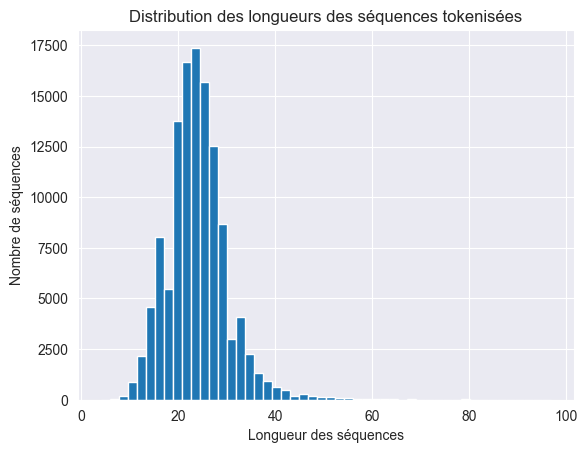

Longueur max naturelle : 97
Longueur moyenne : 23.914783333333332


In [141]:
texts = df["text_cleaned"].to_list()
labels = df["label"].to_list()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
lengths = [len(seq) for seq in sequences]

import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)
plt.xlabel("Longueur des séquences")
plt.ylabel("Nombre de séquences")
plt.title("Distribution des longueurs des séquences tokenisées")
plt.show()

print("Longueur max naturelle :", max(lengths))
print("Longueur moyenne :", sum(lengths)/len(lengths))

In [142]:
from collections import Counter
def count_unique_words(texts):
    # Calcule le nombre de mots uniques dans une liste de textes.
    word_counter = Counter()
    for text in texts:
        word_counter.update(text.split())
    # texts = df["text_cleaned"].to_list()

    return len(word_counter), word_counter

vocab_size, word_freq = count_unique_words(texts)
print(word_freq.most_common(10))
print("Nombre de mots uniques :", vocab_size)

[('say', 28722), ('new', 21402), ('reuters', 17251), ('ap', 16153), ('gt', 13222), ('lt', 13177), ('u', 12334), ('year', 10907), ('company', 10043), ('quot', 9593)]
Nombre de mots uniques : 51756


# Embending

In [143]:
# tokenized_texts = [text.split() for text in texts]
# w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=2, workers=4, sg=1)
# w2v_model.build_vocab(tokenized_texts, progress_per=1000)
# w2v_model.train(tokenized_texts, total_examples=w2v_model.corpus_count, epochs=10)

In [144]:
from gensim.models import FastText

# Tokenisation du texte avant de fit le modele d'embending :
tokenized_texts = [text.split() for text in texts]

# Tes textes sont déjà tokenisés et lemmatisés : `tokenized_texts`
fasttext_model = FastText(
    sentences=tokenized_texts,
    vector_size=100,      # dimension des vecteurs
    window=5,             # taille du contexte
    min_count=2,          # ignorer les mots trop rares
    workers=4,            # threads
    sg=1,                 # 1 = skip-gram, 0 = CBOW
    epochs=10             # nombre d'époques
)

In [145]:
# Creation du dictionnaire de Fasttext
word_index = {word: idx + 1 for idx, word in enumerate(fasttext_model.wv.index_to_key)}
vocab_size = len(word_index) + 1  # +1 pour le padding

# Texte vers séquences d’index
def encode_text(tokens):
    return [word_index[word] for word in tokens if word in word_index]

encoded_texts = [encode_text(tokens) for tokens in tokenized_texts]

# Padding pour avoir toute les sequences d'une meme longueure
MAX_LEN = 100
padded_texts = pad_sequences(encoded_texts, maxlen=MAX_LEN, padding='post')

In [146]:
# Matrice embedding
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i] = fasttext_model.wv[word]


In [147]:
# Creation de la couche d'embending
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

# Création du modèle


In [148]:
model = Sequential([
    embedding_layer,
    # Convolution pour capter les n-grammes importants
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    # Bidirectional LSTM pour le contexte global
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    # Classification finale
    Dense(4, activation='softmax')
])

# Compilation du modèle
model.compile(
    loss='sparse_categorical_crossentropy',  # ou 'categorical_crossentropy' si one-hot
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.build(input_shape=(None, MAX_LEN))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 100)       │     3,379,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,542,460 (13.51 MB)

 Trainable params: 163,460 (638.52 KB)

 Non-trainable params: 3,379,000 (12.89 MB)

In [149]:
X = padded_texts
y = labels

# X = tes textes tokenisés et paddés (e.g. padded_texts)
# y = labels (0, 1, 2, 3 pour AG News)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

# Entrainement du modele

In [150]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping pour stopper l'entrainement si plus de progrès après 3 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,          # arrêt si pas d'amélioration pendant 3 epochs
    restore_best_weights=True
)

params = {
    "epochs": 10,
    "batch_size": 64,
    "learning_rate": 0.001,
}

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=params["batch_size"],
    epochs=params["epochs"],
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 102s 60ms/step - accuracy: 0.8676 - loss: 0.3931 - val_accuracy: 0.9096 - val_loss: 0.2690
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 96s 57ms/step - accuracy: 0.9081 - loss: 0.2696 - val_accuracy: 0.9135 - val_loss: 0.2525
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 107s 63ms/step - accuracy: 0.9177 - loss: 0.2381 - val_accuracy: 0.9218 - val_loss: 0.2327
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 113s 67ms/step - accuracy: 0.9254 - loss: 0.2122 - val_accuracy: 0.9159 - val_loss: 0.2522
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 103s 61ms/step - accuracy: 0.9332 - loss: 0.1911 - val_accuracy: 0.9222 - val_loss: 0.2335
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 101s 60ms/step - accuracy: 0.9409 - loss: 0.1671 - val_accuracy: 0.9067 - val_loss: 0.2749


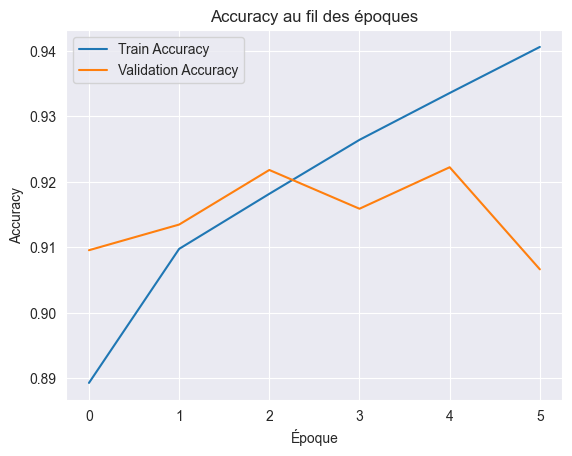

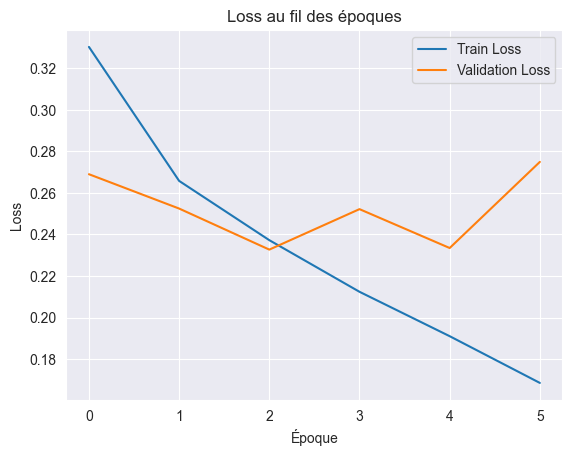

In [151]:
import matplotlib.pyplot as plt

# Courbe de précision (accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy au fil des époques')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Courbe de perte (loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss au fil des époques')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [152]:
print(history.history)

{'accuracy': [0.8893240690231323, 0.9097870588302612, 0.9181944727897644, 0.9264351725578308, 0.9335833191871643, 0.9406203627586365], 'loss': [0.3302851617336273, 0.26578572392463684, 0.2372516244649887, 0.21240000426769257, 0.1910277009010315, 0.16852694749832153], 'val_accuracy': [0.909583330154419, 0.9135000109672546, 0.921833336353302, 0.9159166812896729, 0.922249972820282, 0.9066666960716248], 'val_loss': [0.2690012753009796, 0.2524685859680176, 0.2327081859111786, 0.25218909978866577, 0.23347552120685577, 0.27493271231651306]}


# Test du modele sur le données restante du dataset

In [153]:
test = pl.DataFrame(ds["test"][:])

In [154]:
test_clean = test.with_columns([
    pl.col("text").map_elements(preprocessing, return_dtype=pl.String).alias("text_cleaned")
])

In [155]:
# Traitement du texte avant l'utilisation du model
test_texts = test_clean["text_cleaned"].to_list()
test_labels = test_clean["label"].to_list()
tokenized_texts_test = [text.split() for text in test_texts]
encoded_texts_test = [encode_text(tokens) for tokens in tokenized_texts_test]
padded_texts_test = pad_sequences(encoded_texts_test, maxlen=MAX_LEN, padding='post')

X_test = np.array(padded_texts_test)
y_test = np.array(test_labels)

In [156]:
# Evaluation du modele
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print(f"Loss sur le test set : {test_loss:.4f}")
print(f"Accuracy sur le test set : {test_accuracy:.4f}")

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9118 - loss: 0.2568
Loss sur le test set : 0.2476
Accuracy sur le test set : 0.9128


In [157]:
# Prédictions probabilistes (softmax output)
y_pred_prob = model.predict(X_test, batch_size=64)

# Prédictions de classes (indice de la plus grande probabilité)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1900
           1       0.96      0.98      0.97      1900
           2       0.89      0.87      0.88      1900
           3       0.87      0.91      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



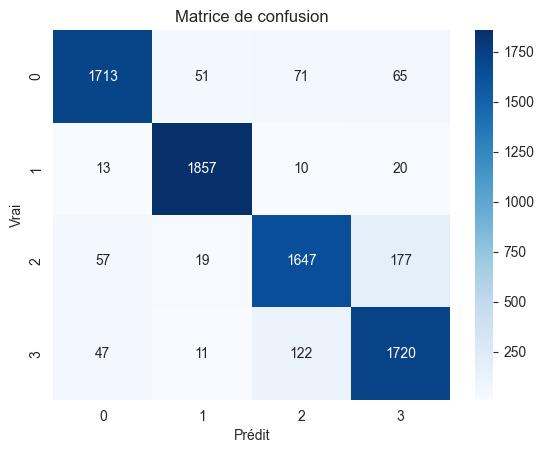

In [158]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_classes))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de confusion')
plt.show()

In [159]:
# Test avec du texte hors AG News
validation = [
    "Despite numerous concerns — including the Israel-Iran war, trade tensions, a growing federal deficit, immigration raids, low business confidence, and expected profit declines — the stock market remains resilient. The S&P 500 is close to its record high, thanks to eased trade policies, stable inflation, and a still-strong economy. However, beneath the surface, warning signs persist. Derivatives markets suggest investors expect a future downturn, and concerns over the $35 trillion U.S. debt remain. Analysts warn that the market's calm appearance masks significant underlying uncertainty.",
    "The 25-year-old Swedish pole vaulter broke his own world record for the twelfth time since 2020 on Sunday. He set the new mark at 6.28 meters during a meet in Stockholm, Sweden, in front of his home crowd.",
    "In twenty months, more than 55,000 Palestinians have been killed in the Gaza Strip, and nearly 950 in the occupied West Bank. But Israel’s destructive campaign began well before October 7, 2023. For over seventy-five years, Israel has done everything to make a Palestinian state impossible, according to Monique Chemillier-Gendreau, a professor of public law and political science, expert in international law and state theory, legal adviser before international courts, and author of Making a Palestinian State Impossible: Israel’s Goal Since Its Creation.",
    "Gemini Automatically Summarizes Your PDFs and Tells You What to Do Next. Gemini has been able to interact with PDF files for some time now. But a new feature significantly boosts its usefulness."
]

proccessed_val = [preprocessing(text) for text in validation]
tokenized_texts_val = [text.split() for text in proccessed_val]
encoded_texts_val = [encode_text(tokens) for tokens in tokenized_texts_val]
padded_texts_val = pad_sequences(encoded_texts_val, maxlen=MAX_LEN, padding='post')
X_val = np.array(padded_texts_val)

predicted_prob = model.predict(X_val)
predicted_classes = np.argmax(predicted_prob, axis=1)

for i, (raw, cleaned, pred) in enumerate(zip(validation, proccessed_val, predicted_classes)):
    label_str = label_names[pred]
    print(f"Phrase {i+1} : \"{raw}\"")
    print(f" → Prétraité : \"{cleaned}\"")
    print(f" → Classe prédite : {pred} ({label_str})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Phrase 1 : "Despite numerous concerns — including the Israel-Iran war, trade tensions, a growing federal deficit, immigration raids, low business confidence, and expected profit declines — the stock market remains resilient. The S&P 500 is close to its record high, thanks to eased trade policies, stable inflation, and a still-strong economy. However, beneath the surface, warning signs persist. Derivatives markets suggest investors expect a future downturn, and concerns over the $35 trillion U.S. debt remain. Analysts warn that the market's calm appearance masks significant underlying uncertainty."
 → Prétraité : "despite numerous concern include war trade tension grow federal deficit immigration raid low business confidence expect profit decline stock market remain resilient p close record high thanks ease trade policy stable inflation economy however beneath surface warn sign persist derivative market suggest investor expect future downturn concer

In [160]:
predicted_prob

array([[1.9662531e-01, 1.4509244e-02, 5.6419837e-01, 2.2466695e-01],
       [7.8886576e-02, 8.9553469e-01, 1.5456941e-02, 1.0121824e-02],
       [9.8354548e-01, 5.4722081e-04, 8.7873414e-05, 1.5819432e-02],
       [1.0598205e-02, 9.1988093e-04, 1.3794596e-02, 9.7468722e-01]],
      dtype=float32)

In [161]:
# Sauvegarde de l'entrainement du model
import json
import os
from datetime import datetime

def save_training_log(history, params, y_true, y_pred, conf_matrix, log_dir="training_logs"):
    import json
    import os
    from datetime import datetime

    os.makedirs(log_dir, exist_ok=True)

    # Générer le rapport de classification sous forme de dict
    report_dict = classification_report(y_true, y_pred, output_dict=True)

    log_data = {
        "date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "subset_size" : subset_size,
        "params": params,
        "metrics": {
            "loss": history.history.get("loss", []),
            "accuracy": history.history.get("accuracy", []),
            "val_loss": history.history.get("val_loss", []),
            "val_accuracy": history.history.get("val_accuracy", [])
        },
        "classification_report": report_dict,
        "confusion_matrix": conf_matrix.tolist(),
    }
    epochs = params["epochs"]
    filename = os.path.join(log_dir, f"training_log_{epochs}_{subset_size}.json")

    with open(filename, "w") as f:
        json.dump(log_data, f, indent=4)

    print(f"Logs sauvegardés dans {filename}")

In [162]:
# Sauvegarde des logs
save_training_log(history, params, y_test, y_pred_classes, cm)

#Sauvegarde du model
epochs = params["epochs"]
model.save(f"DL_Models/model_DL_{epochs}_{subset_size}.keras")

Logs sauvegardés dans training_logs/training_log_20250621_160342.json


In [163]:
# import joblib
# joblib.dump(word_index, "word_index.pkl")
# fasttext_model.save("fasttext_model.bin")